In [1]:
## For debbugging
%load_ext autoreload

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
## for debugging:
%aimport mlp.keyword
%aimport mlp.tools
%aimport mlp.tree
%autoreload 1
from mlp.keyword import *

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import spacy, textacy, platform
print(
    f'Textacy: \t{textacy.__version__:}'+\
    f'\nspaCy: \t{spacy.__version__:>13}'+\
    f'\nPython: \t{platform.python_version()}'
    )

Textacy: 	0.4.1
spaCy: 	        1.9.0
Python: 	3.6.3


In [4]:
data_directory = os.path.join(module_path,'./data', 'gs_data')
nl_col = {
    "Description": 5,
    "Resolution": 6
}

#TODO
# meta_col = {

# }

kex_gs = KeywordExtractor('Maintenance_All_Clean.xlsx',
                       nlp_cols=nl_col,
#                       meta_cols = meta_col,
                       special_replace={' -': '; '},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

354it [00:00, 3534.80it/s]

making new file...


3435it [00:00, 5065.01it/s]


Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


In [5]:
# what we extracted...we'll be using 'RawText'
kex_gs.df.head()

,Description,Resolution,RawText
0,Broken bar feeder chain,Repaired,break bar feeder chain repair
1,No power,Replaced pin in pendant and powered machine; P...,no power replace pin in pendant and power mach...
2,Smartscope harness broken,Parts ordered / Tech repaired,smartscope harness break part order tech repair
3,Check / Charge Accumulators,Where OK,check charge accumulator where ok
4,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,hyd leak at saw atachment replace seal in saw ...


In [6]:
# use this to make a properly formatted thesaurus file for human-annotation
# kex_gs.gen_vocab('new_tag_vocab.csv', notes=True)  # rename to match e.g. hvac_vocab.csv


In [7]:
# "fit" a thesaurus to the data
kex_gs.fit(vocab='tag_vocab.csv')
kex_gs.vocab.head(n=7)

,NE,alias,note
token,,,
replace,S,replace,NaN
unit,I,unit,NaN
motor,I,motor,NaN
spindle,I,spindle,NaN
leak,P,leak,NaN
valve,I,valve,NaN
replaced,S,replace,NaN


In [8]:
# tag the data, saving to a new DF (instead of internally)

df_pred = kex_gs.transform(save=False)
df_pred.head()

100%|██████████| 3431/3431 [00:14<00:00, 241.77it/s]


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,break bar feeder chain repair,"feeder, bar_feeder, chain, bar_feeder_chain, b...",broken,repair,,,
1,no power replace pin in pendant and power mach...,"machine, pendant, pin, cable","short, power",replace,possible,replace pin,
2,smartscope harness break part order tech repair,person,broken,"repair, order",,,"harness, smartscope"
3,check charge accumulator where ok,accumulator,,"check, charge",ok,,
4,hyd leak at saw atachment replace seal in saw ...,"saw_attachment, saw, hydraulic, attachment, seal",leak,replace,see,,"reapir, ml"


In [9]:
# tag-complete work-orders?
print(df_pred[df_pred.Unknown ==''].shape[0])
df_pred[df_pred.Unknown ==''].head()

1134


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,break bar feeder chain repair,"feeder, bar_feeder, chain, bar_feeder_chain, b...",broken,repair,,,
1,no power replace pin in pendant and power mach...,"machine, pendant, pin, cable","short, power",replace,possible,replace pin,
3,check charge accumulator where ok,accumulator,,"check, charge",ok,,
5,cs1008 setup change over from arc1004 complete...,"unit, thread_unit, thread",,"setup, wire, change, complete",,,
7,check and charge accumulator check and charge,accumulator,,"check, charge",,check and charge,


In [10]:
# tag-empty? 
print(df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].shape[0])
df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].head()

3


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
631,unload automation not return,,,,,,"unload, automation, return"
2562,camshaft standstill gary,,,,,,camshaft
3185,disti water empty water fill,,,,,,"disti, fill, water"


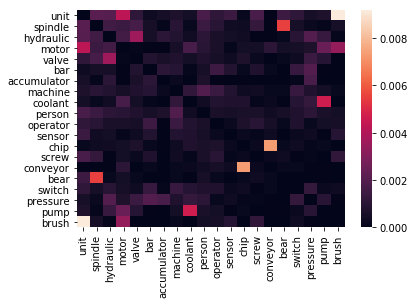

In [24]:
from mlp import tree

tag_events = tree.get_onehot(df_pred, 'Items', topn=500)
tag_similarity = tree.node_dist_mat(tag_events)

sns.heatmap(tag_similarity.iloc[:20,:20])


In [19]:
D = tree.heymann_taxonomy(tag_similarity)

100%|██████████| 492/492 [00:01<00:00, 301.15it/s] 


In [20]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'unit')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'unit'), outfile)

In [21]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1500 - margin.right - margin.left,
    height = 1200 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Writing f2.template


In [22]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [23]:
f2(w=1500,h=1200)

## HVAC Data

In [11]:
data_directory = os.path.join(module_path,'./data', 'hvac_data')

nl_col = {
    "Description": 5,
    "Resolution": 248
}

meta_col = {
    "AssetID": 6,
    "Location": 7,
    "Assigned": 10,
    "Reported": 43,
    "SolveDate": 11,
    "ReportDate": 44
}

kex_hvac = KeywordExtractor('hvac_raw.xlsx',
                       nlp_cols=nl_col,
                       meta_cols = meta_col,
                       special_replace={'action taken:': '',
                                        ' -': '; ',
                                        '- ': '; ',
                                        'too hot': 'too_hot',
                                        'to hot': 'too_hot',
                                        'too cold': 'too_cold',
                                        'to cold': 'too_cold'},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

305it [00:00, 3046.30it/s]

making new file...


16986it [00:08, 2002.50it/s]


In [12]:
# what we extracted...we'll be using 'RawText'
kex_hvac.df.head()

,Description,AssetID,Location,Assigned,SolveDate,Reported,ReportDate,Resolution,RawText
0,CHARGE ALL M/S AND PM'S TO THIS ORDER,NaN,GAITHER,FEDERLIN,2009-04-02 14:15:38,LEM801,2009-02-12 14:27:33,"for site , other that AML Action Taken:Complete.",charge all m s and pm be to this order for sit...
1,CHARGE ALL M/S AND PM'S TO THIS ORDER FOR THE AML,NaN,215-1,FEDERLIN,2009-04-02 14:15:39,LEM801,2009-02-12 14:44:55,Action Taken: Time charged to cover PM's as ne...,charge all m s and pm be to this order for the...
2,"ADJUST,REPAI OR REPLACE FREEZE STAT",301 HV-4,301-B184,FEDERLIN,2009-04-02 14:15:41,HWRJR,2009-02-15 23:25:01,Action Taken:Reset POC Ed,adjust repai or replace freeze stat reset poc ed
3,"RESET,ADJUST OR REPAIR FREEZE STAT",304 ACU-1,304-200,FEDERLIN,2009-04-02 14:15:42,HWRJR,2009-02-17 04:20:08,Action Taken: restart POC Ed,reset adjust or repair freeze stat restart poc ed
4,"RSET,ADJUST OR REPAIR FREEZE STAT",220 ACU-8,220-400,FEDERLIN,2009-06-25 08:17:33,HWRJR,2009-02-17 04:22:38,reset freezestat,rset adjust or repair freeze stat reset freeze...


In [13]:
# use this to make a properly formatted thesaurus file for human-annotation
kex_hvac.gen_vocab('tag_vocab.csv', notes=True)  # rename to match e.g. hvac_vocab.csv


In [14]:
# "fit" a thesaurus to the data
kex_hvac.fit(vocab='hvac_vocab.csv')
kex_hvac.vocab.head()

,NE,alias,note
token,,,
room,I,room,NaN
replace,S,replace,NaN
find,S,find,NaN
check,S,check,NaN
action_take,X,action_take,NaN


In [15]:
# tag the data, saving to a new DF (instead of internally)
df_pred = kex_hvac.transform(save=False)
df_pred.head()

100%|██████████| 16986/16986 [01:22<00:00, 206.50it/s]


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,charge all m s and pm be to this order for sit...,site,,"preventative_maintenance, complete, order",s,,"m, charge, aml, charge all m"
1,charge all m s and pm be to this order for the...,,request,"preventative_maintenance, order",s,,"m, 's, charge, time, aml, charge all m, cover"
2,adjust repai or replace freeze stat reset poc ed,"thermostat, freezestat, poc",,"reset, adjust, replace",,,"ed, repai"
3,reset adjust or repair freeze stat restart poc ed,"thermostat, freezestat, poc",,"reset, adjust, restart, repair",,,ed
4,rset adjust or repair freeze stat reset freeze...,"freezestat, thermostat",,"reset, adjust, repair",,,


In [17]:
# tag-complete work-orders?
print(df_pred[df_pred.Unknown ==''].shape[0])
df_pred[df_pred.Unknown ==''].head()

963


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
4,rset adjust or repair freeze stat reset freeze...,"freezestat, thermostat",,"reset, adjust, repair",,,
15,too_hot,,too_hot,,,,
18,too_hot,,too_hot,,,,
23,too_cold,,too_cold,,,,
26,remove motor pulley and install on new motor s...,"pulley, install, switch, belt, motor",old,remove,new,,


In [18]:
# tag-empty? 
print(df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].shape[0])
df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].head()

21


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
618,b349-mod-345b b367-mod-363b a368-mod-362b,,,,,,
877,humidty too high b331,,,,,,"humidty too high, b331, high, humidty"
1642,ice machine not work a-100,,,,,,"ice, machine, ice machine, a-100, work"
1765,humidty real high b217,,,,,,"b217, high, real, humidty"
1807,humidty too high rm f-013,,,,,,"humidty too high, high, humidty, rm"


## PSU Data, no tagged keywords (yet)

In [19]:
data_directory = os.path.join(module_path, './data', 'psu_data')
nl_col = {
    "ProblemDesc": 11,
    "Prob_cause": 12,
    "RepRes": 19
}

#TODO
# meta_col = {

# }

kex_psu = KeywordExtractor('psu_data.xlsx',
                       nlp_cols=nl_col,
#                       meta_cols = meta_col,
#                        special_replace={' -': '; '},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

540it [00:00, 5396.90it/s]

making new file...


8887it [00:01, 6011.82it/s]


Replacing NaN
Replacing NaN
Replacing NaN


In [21]:
kex_psu.df.head()

,ProblemDesc,Prob_cause,RepRes,RawText
0,Vacuum pump is leaking oil.,add 500 ml fomblin,Replaced Vacuum Pump,vacuum pump be leak oil add 500 ml fomblin rep...
1,Airflow readings range from 50 FPM to 85FPM. ...,add 500 ml fomblin,Adjust Airspeed,airflow reading range from 50 fpm to 85fpm may...
2,Bottom shelf Connection #4 (marked) Wrap conne...,adjust printhead pressure screws,,bottom shelf connection 4 mark wrap connection...
3,Camera on autosaw needs cleaned. Having proble...,verify machine operation and perform leak test,,camera on autosaw need clean have problem pick...
4,pump at encapsulater is low on oil,Mims wasn't hooked up at time for calibration ...,Added Oil,pump at encapsulater be low on oil mim be not ...


In [22]:
kex_psu.gen_vocab('psu_vocab.csv', notes=True)

## Automotive data, no tagged keywords (yet)

In [23]:
data_directory = os.path.join(module_path, './data', 'auto_data')

nl_col = {
    "DESCRIPTION": 5
}

#TODO
# meta_col = {

# }

kex_auto = KeywordExtractor('auto_raw.xlsx',
                       nlp_cols=nl_col,
#                       meta_cols = meta_col,
#                       special_replace={'Action Taken:': ''},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

1103it [00:00, 11024.02it/s]

making new file...


12410it [00:01, 7947.09it/s]

Replacing NaN


21281it [00:02, 7890.76it/s]

Replacing NaN


31218it [00:04, 6366.12it/s]

Replacing NaN
Replacing NaN
Replacing NaN


38756it [00:05, 7307.12it/s]

Replacing NaN


67217it [00:08, 7614.86it/s]


In [24]:
# use this to make a properly formatted thesaurus file for human-annotation
kex_auto.gen_vocab('auto_vocab.csv', notes=True)  # rename to match e.g. hvac_vocab.csv


## Mining Data, no vocab (yet)

In [ ]:
data_directory = os.path.join(module_path, './data', 'mine_data')

# nl_col = {
#     "OriginalShorttext": 2
# }
# meta_col = {
#     "BscStartDate":0,
#     "Asset":1,
#     "PMType":3,
#     "Cost":4
# }

nl_col = {
    "ShortText": 4
}
meta_col = {
    "BscStartDate":2,
    "AssetID":13
}

# kex_mine = KeywordExtractor('mine_data.csv',
kex_mine = KeywordExtractor('loader_work_orders_sanitised.csv',
                       nlp_cols=nl_col,
                      meta_cols = meta_col,
#                       special_replace={'Action Taken:': ''},
                       wdir=data_directory,
                       keep_temp_files=False
                      )

Unsupported format, or corrupt file: Expected BOF record; found b'"WOType"' ... did not find .xlsx file, attempting .csv ...


1611it [00:00, 16106.94it/s]

making new file...


18280it [00:01, 10780.40it/s]

Replacing NaN


31627it [00:03, 8713.49it/s] 

Replacing NaN
Replacing NaN


41821it [00:05, 8291.53it/s]

Replacing NaN
Replacing NaN


52457it [00:06, 8361.39it/s]

Replacing NaN


59096it [00:06, 8854.88it/s]

Replacing NaN


82519it [00:10, 8249.07it/s]

Replacing NaN


91976it [00:11, 8170.74it/s]

Replacing NaN


102021it [00:12, 8138.93it/s]

Replacing NaN
Replacing NaN
Replacing NaN


147999it [00:17, 8409.47it/s]

Replacing NaN


161716it [00:19, 8288.10it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


172196it [00:20, 8303.34it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


181936it [00:21, 8270.25it/s]

Replacing NaN
Replacing NaN
Replacing NaN


192702it [00:23, 8273.06it/s]

Replacing NaN
Replacing NaN


201555it [00:24, 8256.97it/s]

Replacing NaN


211713it [00:25, 8312.12it/s]

Replacing NaN
Replacing NaN


242910it [00:29, 8234.09it/s]

Replacing NaN


251435it [00:30, 8138.03it/s]

Replacing NaN
Replacing NaN


270983it [00:33, 8094.01it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


303041it [00:37, 8152.94it/s]

Replacing NaN


309456it [00:37, 8221.07it/s]

Replacing NaN


318214it [00:39, 8155.72it/s]

Replacing NaN
Replacing NaN
Replacing

330815it [00:40, 8091.43it/s]

 NaN
Replacing NaN


370177it [00:45, 8100.78it/s]

Replacing NaN


382638it [00:46, 8145.04it/s]

Replacing NaN
Replacing NaN


393108it [00:48, 8187.83it/s]

Replacing NaN


409980it [00:49, 8264.51it/s]

Replacing NaN


420152it [00:51, 8218.01it/s]

Replacing NaN
Replacing NaN


432776it [00:52, 8258.39it/s]

Replacing NaN
Replacing NaN


462244it [00:55, 8267.61it/s]

Replacing NaN


472771it [00:57, 8268.86it/s]

Replacing NaN


481266it [00:58, 8274.59it/s]

Replacing NaN
Replacing NaN


491963it [00:59, 8267.78it/s]

Replacing NaN


503202it [01:00, 8287.27it/s]

Replacing NaN
Replacing NaN


512119it [01:02, 8256.37it/s]

Replacing NaN
Replacing NaN


531923it [01:04, 8226.21it/s]

Replacing NaN


540861it [01:06, 8193.94it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


551183it [01:07, 8163.56it/s]

Replacing NaN
Replacing NaN
Replacing NaN


561876it [01:09, 8113.45it/s]

Replacing NaN
Replacing NaN


579971it [01:11, 8150.87it/s]

Replacing NaN
Replacing NaN


591889it [01:13, 8058.62it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


602007it [01:14, 8044.75it/s]

Replacing NaN
Replacing NaN
Replacing NaN


610964it [01:16, 8022.89it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


620388it [01:17, 7973.02it/s]

Replacing NaN
Replacing NaN
Replacing NaN
Replacing NaN


629304it [01:18, 7984.65it/s]

Replacing NaN
Replacing NaN


639773it [01:20, 7993.30it/s]

Replacing NaN


652475it [01:21, 7964.42it/s]

Replacing NaN


660962it [01:23, 7937.42it/s]

Replacing NaN


672204it [01:24, 7939.50it/s]

Replacing NaN


682039it [01:25, 7936.46it/s]

Replacing NaN


688533it [01:26, 7974.89it/s]

Replacing NaN


696211it [01:27, 7944.67it/s]


In [48]:
# use this to make a properly formatted thesaurus file for human-annotation
kex_mine.gen_vocab('mine_vocab_full.csv', notes=True)  # rename to match e.g. hvac_vocab.csv


In [44]:
# "fit" a thesaurus to the data
kex_mine.fit(vocab='mine_vocab.csv')
kex_mine.vocab.head()

,NE,alias,note
token,,,
replace,S,replace,NaN
leak,P,leak,NaN
repair,S,repair,NaN
bucket,I,bucket,NaN
engine,I,engine,NaN


In [45]:
# tag the data, saving to a new DF (instead of internally)
df_pred = kex_mine.transform(save=False)
df_pred.head()

100%|██████████| 696109/696109 [42:48<00:00, 271.05it/s]


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,replace lube tank fill hose,"hose, lubrication, tank",,"replace, fill",,,
1,check rotary head alignment,,,check,,,"rotary head, rotary head alignment, rotary, al..."
2,reweld shock sub to rotary head,,,,,,"rotary head, reweld, sub, sub to rotary, rewel..."
3,centre tank not fill with water,"tank, water",,fill,,,centre
4,hydraulic pump failure,"pump, hydraulic",,,,,failure


In [46]:
# tag-complete work-orders?
print(df_pred[df_pred.Unknown ==''].shape[0])
df_pred[df_pred.Unknown ==''].head()

66203


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
0,replace lube tank fill hose,"hose, lubrication, tank",,"replace, fill",,,
14,refit rh bucket pin,"bucket_pin, right_hand, bucket, pin",,refit,,,
15,replace filter,filter,,replace,,,
33,replace outer filter,"outer, filter",,replace,,,
37,replace air cleaner,air,,"replace, clean",,,


In [47]:
# tag-empty? 
print(df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].shape[0])
df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].head()

115782


,RawText,Items,Problem,Solution,eXcess,Redundant,Unknown
2,reweld shock sub to rotary head,,,,,,"rotary head, reweld, sub, sub to rotary, rewel..."
25,e m relocate a c from dre16,,,,,,"e, m, relocate, relocate a c, e m, m relocate, c"
49,reweld shock sub to rotary head,,,,,,"rotary head, reweld, sub, sub to rotary, rewel..."
76,mimdril restock part,,,,,,"mimdril, mimdril restock, restock"
77,mimdril restock part,,,,,,"mimdril, mimdril restock, restock"


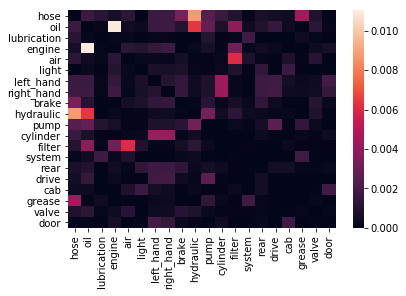

In [49]:
from mlp import tree

tag_events = tree.get_onehot(df_pred, 'Items', topn=1000)
tag_similarity = tree.node_dist_mat(tag_events)

sns.heatmap(tag_similarity.iloc[:20,:20])


In [50]:
D = tree.heymann_taxonomy(tag_similarity)

 62%|██████▏   | 108/175 [00:00<00:00, 1065.59it/s]

oil


100%|██████████| 175/175 [00:00<00:00, 701.25it/s] 


In [51]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'oil')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'oil'), outfile)

In [52]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1500 - margin.right - margin.left,
    height = 1200 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [53]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [54]:
f2(w=1500,h=1200)